In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [14]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first().date
most_recent

'2017-08-23'

Text(0, 0.5, 'Inches')

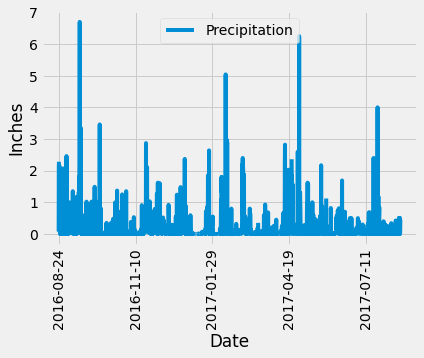

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
past_year = dt.datetime.strptime(most_recent, "%Y-%m-%d") - dt.timedelta(days=365)
past_year
# Perform a query to retrieve the data and precipitation scores
precp_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date>=past_year).order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precp_df = pd.DataFrame(precp_scores, columns = ["Date", "Precipitation"])
precp_df.set_index("Date", inplace = True)
precp_df
# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
precp_plot = precp_df.plot(rot = 90).get_figure()
plt.ylabel("Inches")
# plt.plot(precp_df)
# plt.show


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precp_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
inspector = inspect(engine)
inspector.get_table_names
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(station.id).count()
stations

9

In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = most_active[0][0]
lowest = session.query(func.min(measurement.tobs)).filter(measurement.station == active_station).all()
highest = session.query(func.max(measurement.tobs)).filter(measurement.station == active_station).all()
average = session.query(func.avg(measurement.tobs)).filter(measurement.station == active_station).all()
print(lowest)
print(average)
print(highest)

[(54.0,)]
[(71.66378066378067,)]
[(85.0,)]


In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_best = session.query(measurement.station, measurement.tobs, measurement.date).filter(measurement.station == active_station).filter(measurement.date >= past_year).all()
temp_best
temp_best_df = pd.DataFrame(temp_best)
temp_best_df.set_index("station", inplace = True)
temp_best_df

,tobs,date
station,,
USC00519281,77.0,2016-08-24
USC00519281,80.0,2016-08-25
USC00519281,80.0,2016-08-26
USC00519281,75.0,2016-08-27
USC00519281,73.0,2016-08-28
...,...,...
USC00519281,77.0,2017-08-14
USC00519281,77.0,2017-08-15
USC00519281,76.0,2017-08-16


Text(0.5, 0, 'Temperature')

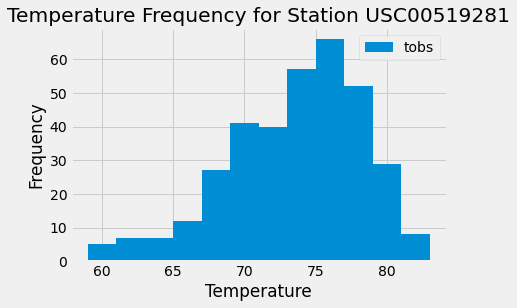

In [64]:
temp_best_df.plot.hist(by='station', bins = 12)
plt.title("Temperature Frequency for Station USC00519281")
plt.xlabel("Temperature")
          

# Close session

In [65]:
# Close Session
session.close()